# Mapping in Python

For my maps, I use matplotlib Basemap. It is the most complete library available at the moment, however, in a few years it is supposed to be retired and replaced with "cartopy." I've tried using the current version of cartopy to create maps but it doesn't work very well yet in my opinion.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.basemap import Basemap # import the basemap library
import netCDF4 as nc
import cmocean
import numpy as np
import pickle

%matplotlib inline

First, I load my land mask and lons/lats to create the Basemap like usual:

In [2]:
mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])
tmask = np.array(mesh.variables['tmask'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

####  Creating a map

You can use bathymetry that is built in to Basemap to create your map:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


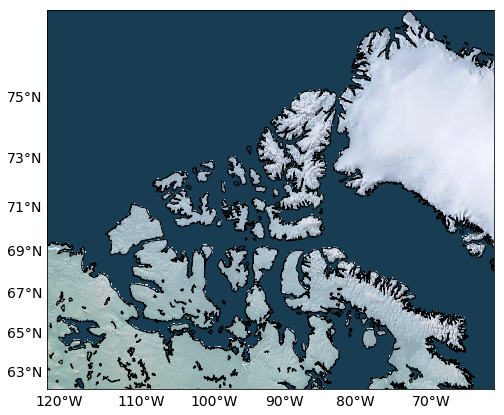

In [29]:
fig, ax1 = plt.subplots(figsize=(8,7))

# Create a basemap object named proj1 (basically sets up the domain and coordinates of your map):
proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='i', width=3.0e6, height=2.55e6, ax=ax1)
# --- possible projections: https://matplotlib.org/basemap/users/mapsetup.html
# --- lat_0: latitude at the center of your map
# --- lon_0: longitude at the center of your map
# --- width: number of pixels for your map (I find it easier to use this option instead of defining the 
#            left and right corner latitudes and longitudes for the map)
# --- height: similar as width


#--------------------------------------------------------------------------------------------------
# Add stuff to your map:
#--------------------------------------------------------------------------------------------------
proj1.shadedrelief()                                        # fill in land with topography
proj1.drawlsmask(ocean_color= "#183C51", land_color="none") # fill in ocean with one color and land transparent
proj1.drawcoastlines()                                      # outline the coasts
# Add markers for degrees longitude and latitude
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14);
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14);

# If you want to save your figure:
# fig.savefig('filename.png', bbox_inches='tight', dpi=300) # dpi is for resolution bbox_inches is to reduce the
                                                          # amount of extra space around the figure

or, you can use your own file to fill the land areas. This is particularly helpful when you are looking at quite zoomed-in regions, since the built-in bathymetry doesn't have very high resolution.

In [4]:
# create a mask for land based on my bathymetry file:
# --- my land mask has the shape of (depth, longitudes, latitudes)
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1), tmask[0,:,:,:]) 

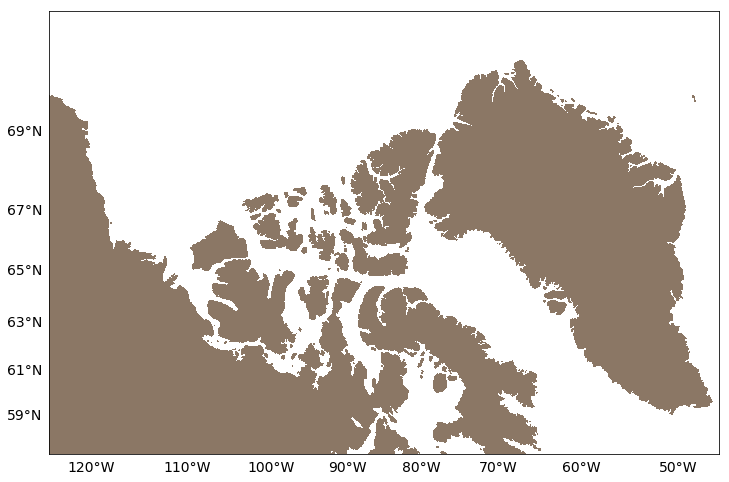

In [14]:
fig, ax1 = plt.subplots(figsize=(12,9))

proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14) 
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)

# convert longitude and latitude into the coordinate system of your map (proj1):
x_model, y_model = proj1(lon, lat)

#--------------------------------------------------------------------------------------------------
# Fill the land areas based on your own land mask:
#--------------------------------------------------------------------------------------------------
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]))

#### Scatter points on a map

Now let's add some scatter points to a map. In this case, I'll want to mark some of the stations at which samples were collected.

In [15]:
longitude_stations = [-80.57,-80.49,-80.49,-91.51,-90.8,-97.45,-96.52,-108.83,-96.75,-120.64,-129.21,-140.03]
latitude_stations  = [74.52,74.31,73.81,74.12,74.53,74.75,73.67,74.13,76.33,75.01,75.81,76.98]

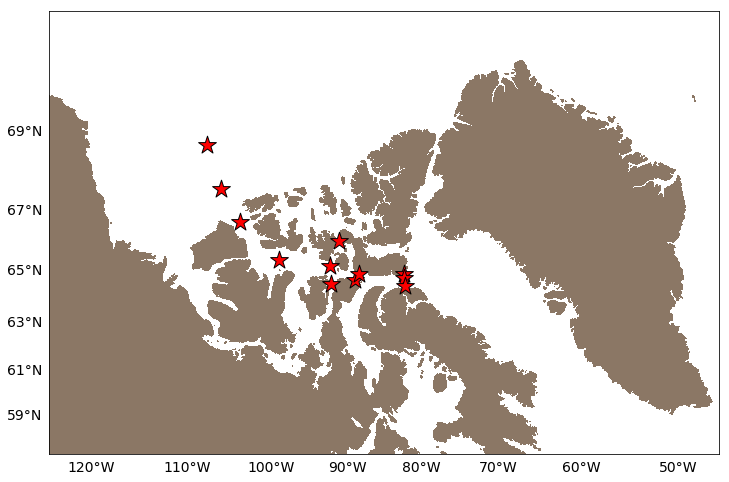

In [16]:
fig, ax1 = plt.subplots(figsize=(12,9))

proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14) 
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]))

#--------------------------------------------------------------------------------------------------
# Add scatter points onto the map:
#--------------------------------------------------------------------------------------------------
x_stns, y_stns = proj1(longitude_stations, latitude_stations)
proj1.scatter(x_stns, y_stns, marker='*', s=350, edgecolor='k', color='r')

Note that you can also make the color of the scatter points proportional to some variable (https://stackoverflow.com/questions/8202605/matplotlib-scatterplot-colour-as-a-function-of-a-third-variable).

#### Contour maps

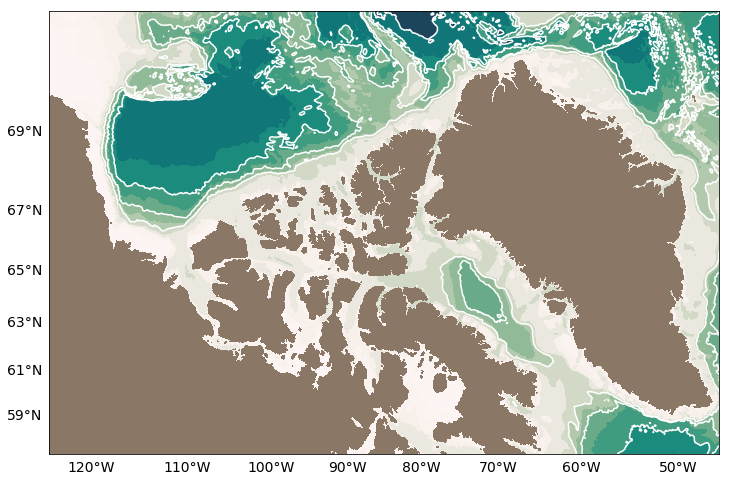

In [17]:
fig, ax1 = plt.subplots(figsize=(12,9))

proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14) 
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)

x_model, y_model = proj1(lon, lat)

#--------------------------------------------------------------------------------------------------
# Contour maps:
#--------------------------------------------------------------------------------------------------
clevels=[0,50,100,200,500,1000,1500,2000,2500,3000,3500,4000,6000]
contour_levels=[1000,2000,3000,4000,5000,6000]
# Ocean depth coloured levels:
proj1.contourf(x_model, y_model, mesh_bathy, cmap=cmocean.cm.tempo, levels=clevels, vmin=0, vmax=6000) 
# White contour levels at specific depths:
proj1.contour(x_model, y_model, mesh_bathy, colors='w', levels=contour_levels) 

# Land mask:
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"])) 

####  Adding multiple sub-maps to one figure:

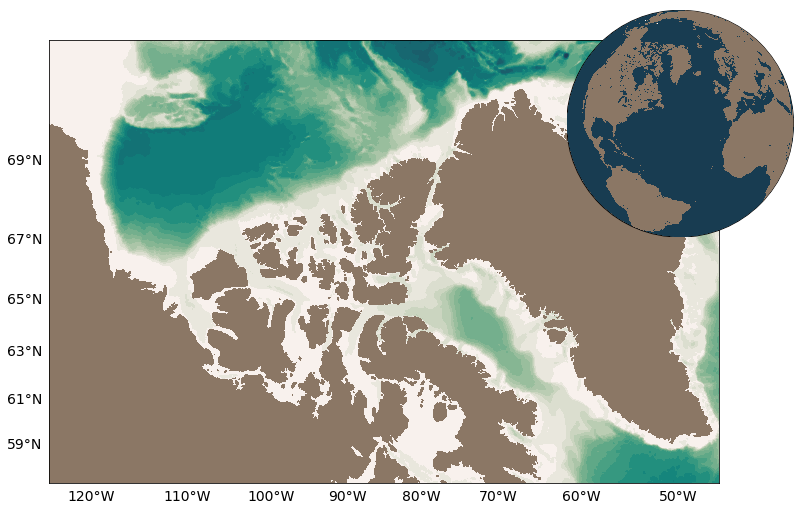

In [26]:
fig, ax1 = plt.subplots(figsize=(12,9))

proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=6000) # ocean bathymetry
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]))

#--------------------------------------------------------------------------------------------------
# add another axis to the same figure to add a globe in the corner:
#--------------------------------------------------------------------------------------------------
ax2   = fig.add_axes([0.68, 0.54, 0.35, 0.35])
# and create a new coordinate system for that map:
proj2 = Basemap(projection='ortho',lon_0=-40,lat_0=40, resolution='h', ax=ax2)
proj2.drawmapboundary(fill_color='white')
proj2.drawlsmask(land_color = "#8b7765", ocean_color="#183C51", resolution = 'h',zorder=2) 